In [1]:
import sys
import os

# Agrega la ruta de src/ al path
SRC_PATH = os.path.abspath(os.path.join("..", "src"))
sys.path.append(SRC_PATH)

# Importar el módulo
from preprocessing.transform import (
    remove_missing_rows,
    clean_column_names,
    encode_categorical,
    scale_numeric,
    drop_columns,
    drop_low_variance,
    separate_features_target
)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arff

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_DIR = "../data/raw"
ADULT_PATH = os.path.join(DATA_DIR, "dataset")
HAR_PATH   = os.path.join(DATA_DIR, "php0gEU7D.arff")
GAS_PATH   = os.path.join(DATA_DIR, "phpN4gaxw.arff")

def load_arff(path):
    with open(path) as f:
        data = arff.load(f)
    columnas = [attr[0] for attr in data["attributes"]]
    df = pd.DataFrame(data["data"], columns=columnas)
    return df

adult_df = load_arff(ADULT_PATH)
print("Adult dataset cargado")
print(f"Dimensiones: {adult_df.shape}")
print(f"Columnas: {adult_df.columns.tolist()}")

har_df = load_arff(HAR_PATH)
print("HAR dataset cargado")
print(f"Dimensiones: {har_df.shape}")
print(f"Columnas: {har_df.columns.tolist()}")

gas_df = load_arff(GAS_PATH)
print("Gas Sensor dataset cargado")
print(f"Dimensiones: {gas_df.shape}")
print(f"Columnas: {gas_df.columns.tolist()}")

Adult dataset cargado
Dimensiones: (32561, 15)
Columnas: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
HAR dataset cargado
Dimensiones: (180, 68)
Columnas: ['Person', 'Activity', 'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Y', 'tBodyAccJerk-mean()-Z', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-std()-Z', 'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z', 'tBodyGyro-std()-X', 'tBodyGyro-std()-Y', 'tBodyGyro-std()-Z', 'tBodyGyroJerk-mean()-X', 'tBodyGyroJerk-mean()-Y', 'tBodyGyroJerk-mean()-Z', 'tBodyGyroJerk-std()-X', 'tBodyGyroJerk-std()-Y

In [3]:


print(f"Dimensiones antes de eliminar nulos: {adult_df.shape}")
adult_df = remove_missing_rows(adult_df)
print(f"Dimensiones después: {adult_df.shape}")

Dimensiones antes de eliminar nulos: (32561, 15)
Dimensiones después: (30162, 15)


In [4]:
adult_df = clean_column_names(adult_df)
print("Columnas renombradas:")
print(adult_df.columns.tolist())

Columnas renombradas:
['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


In [5]:
categorical_cols = adult_df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('income')  # Excluir target
numeric_cols = adult_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [6]:
adult_df = encode_categorical(adult_df, categorical_cols + ['income'])  # Incluye target


In [7]:
adult_df = scale_numeric(adult_df, numeric_cols)


In [8]:
X_adult, y_adult = separate_features_target(adult_df, 'income')


In [9]:
from sklearn.model_selection import train_test_split

X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=42, stratify=y_adult
)

In [10]:
print("Distribución en y_train:")
print(y_train_adult.value_counts(normalize=True))

print("\nDistribución en y_test:")
print(y_test_adult.value_counts(normalize=True))

Distribución en y_train:
income
1    0.751088
0    0.248912
Name: proportion, dtype: float64

Distribución en y_test:
income
1    0.751036
0    0.248964
Name: proportion, dtype: float64


In [11]:
from sklearn.linear_model import LogisticRegression

# Entrenar modelo base
model_adult = LogisticRegression(max_iter=1000, random_state=42)
model_adult.fit(X_train_adult, y_train_adult)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
y_pred_adult = model_adult.predict(X_test_adult)


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test_adult, y_pred_adult)
print(f"Accuracy: {accuracy:.4f}")

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test_adult, y_pred_adult))


Accuracy: 0.8192

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.46      0.56      1502
           1       0.84      0.94      0.89      4531

    accuracy                           0.82      6033
   macro avg       0.78      0.70      0.72      6033
weighted avg       0.81      0.82      0.80      6033



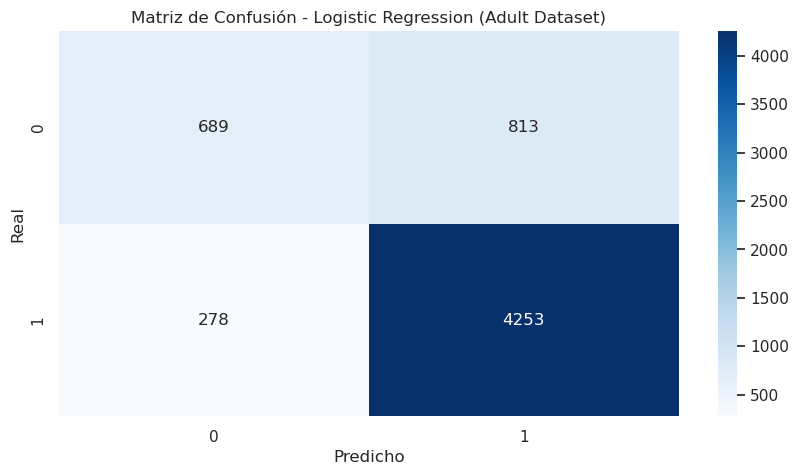

In [14]:
cm = confusion_matrix(y_test_adult, y_pred_adult)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Logistic Regression (Adult Dataset)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


In [15]:
import joblib
import os

# Crear carpeta si no existe
os.makedirs("../models", exist_ok=True)

# Guardar modelo entrenado
joblib.dump(model_adult, "../models/model_adult.joblib")
print("Modelo guardado en models/model_adult.joblib")


Modelo guardado en models/model_adult.joblib


## Dataset: Adult

### Objetivo
Clasificación binaria para predecir si el ingreso de una persona excede los 50,000 USD anuales (`income`).

---

### Transformaciones realizadas

- **Eliminación de valores nulos:** Se eliminaron todas las filas con valores faltantes (`dropna`).
- **Renombrado de columnas:** Limpieza de nombres para homogeneidad y compatibilidad en procesamiento.
- **Codificación de variables categóricas:** Codificadas con `LabelEncoder`, incluyendo la variable objetivo.
- **Escalamiento:** Se aplicó `StandardScaler` a las variables numéricas.

---

### Separación de datos

- División 80/20 estratificada entre entrenamiento y prueba.
- Se mantuvo la proporción original de clases en ambos subconjuntos.

---

### Modelo entrenado

- **Tipo:** `LogisticRegression`
- **Hiperparámetros:** `max_iter=1000`, `random_state=42`
- **Justificación:** Modelo base interpretativo, rápido de entrenar, útil como línea base.

---

### Resultados

- **Accuracy:** 0.8192
- **Classification Report:**

